## Homework 3
#### Group A 23 - Benjamin Panovich, Dennis Hua, Tianyang Bao, Joseph Padilla 
#### Barnstable analysis

In [2]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from arch import arch_model
#from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [3]:
bn = pd.read_excel('barnstable_analysis_data.xlsx',sheet_name='data',index_col=0)
bn

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027
...,...,...
2022-04-29,-0.0876,0.0003
2022-05-31,0.0004,0.0006
2022-06-30,-0.0814,0.0009


In [4]:
log_bn = np.log(1+bn)
log_bn

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0339,0.0026
1926-03-31,-0.0594,0.0026
1926-04-30,0.0378,0.0023
1926-05-28,0.0135,0.0027
...,...,...
2022-04-29,-0.0917,0.0003
2022-05-31,0.0004,0.0006
2022-06-30,-0.0850,0.0009


## Model Volatility and VaR

### 1. historic-based VaR starting at t=61

In [5]:
#first we display r_tilde
bn[r'$\tilde{r}$'] = bn.SPX - bn.TB1M
bn

,SPX,TB1M,$\tilde{r}$
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109
...,...,...,...
2022-04-29,-0.0876,0.0003,-0.0879
2022-05-31,0.0004,0.0006,-0.0002
2022-06-30,-0.0814,0.0009,-0.0824


#### (a) Plot 'best estimate of the time-t VaR based on data thru t-1' 

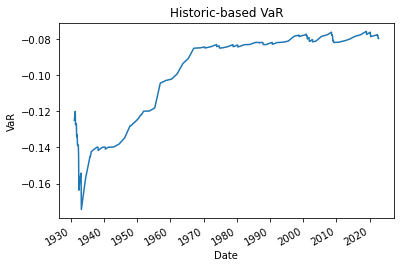

In [6]:
his_VaR = bn[r'$\tilde{r}$'].shift().expanding(min_periods=60).quantile(.05)
his_VaR.plot()

plt.title('Historic-based VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()


#### (b) Frequency of periods when r_tilde is less than (a)

In [7]:
freq = len(bn[r'$\tilde{r}$'][bn[r'$\tilde{r}$'] < his_VaR]) / len(his_VaR.dropna())
round(freq,5)

#freq_var(his_VaR)

0.03

#### (c) Drawbacks of historic VaR
value-at-risk.net/shortcomings-historical-simulation/

VaR here doesn't reflect the 5% percentile. It mostly because the measurement reacts slowly to real market events. It possesses backward looking, which means VaR mostly reflects events/movements in the past. It also distributes equal weight across the time horizon while calculating historic VaR.

### 2. Volatility

##### (a) Plot expanding vol, rolling vol, and vol
vol == stdev

In [8]:
#expanding
vol = (((bn[r'$\tilde{r}$']**2).shift(1).expanding(60).mean())**0.5).to_frame('Expanding Vol')
#rolling
vol['Rolling Vol'] = (((bn[r'$\tilde{r}$']**2).shift(1).rolling(60).mean())**0.5)
#vol CHECK TA SESSION
#vol['Normal Dist'] = bn[r'$\tilde{r}$'].std() #(1.65)**(1/60)


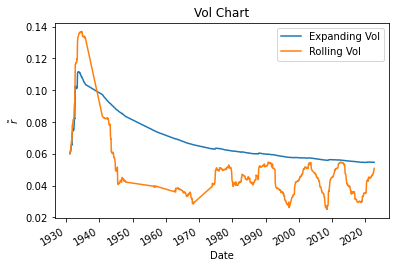

In [9]:
vol.dropna(inplace=True)
vol.plot()

plt.title('Vol Chart')
plt.xlabel('Date')
plt.ylabel(r'$\tilde{r}$')
plt.show()

##### (b) VaR_.05 = -1.65 * vol

In [10]:
VaR = -1.65 * vol
VaR

,Expanding Vol,Rolling Vol
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043
...,...,...
2022-04-29,-0.0901,-0.0776
2022-05-31,-0.0902,-0.0798
2022-06-30,-0.0902,-0.0798


#### (c) Frequency of periods when r_tilde is less than (b)

In [11]:
freq_df = pd.DataFrame(index = ['Freq'], columns = VaR.columns)

In [12]:
VaR['Expanding Vol']

date
1931-01-31   -0.0992
1931-02-28   -0.0992
1931-03-31   -0.1010
1931-04-30   -0.1013
1931-05-29   -0.1023
               ...  
2022-04-29   -0.0901
2022-05-31   -0.0902
2022-06-30   -0.0902
2022-07-29   -0.0902
2022-08-31   -0.0903
Name: Expanding Vol, Length: 820, dtype: float64

In [13]:
#locate all r_tilde from bn and compare them with VaRs
#bn.loc[VaR.index,r'$\tilde{r}$']
for col in freq_df:
    freq_df[col] = len(VaR[bn.loc[VaR.index, r'$\tilde{r}$'] < VaR[col]])/ len(VaR[col].dropna())#.index)
round(freq_df,4)


,Expanding Vol,Rolling Vol
Freq,0.0207,0.05


#### (d) Compare with frequency of historic based var

In [14]:
freq_df['Historic based Vol'] = freq
freq_df

,Expanding Vol,Rolling Vol,Historic based Vol
Freq,0.0207,0.05,0.03


Rolling vol seems to be most aligning/'correct' in term of the percentile percentage as .05 percentile. 
Historic based calculated the vol also by rolling the window of 60, which may result in a similar answer as expanding vol which starts with 60 window.

https://robotwealth.com/rolling-and-expanding-windows-for-dummies/

### 3. CVaR

#### 3.1 Historic CVaR

#### (a) Plot CVaR with percentile .05 

In [15]:
return_data = bn[r'$\tilde{r}$']
historic_CVaR = np.empty(0,float)
historic_CVaR.shape = (-1,len(return_data))
historic_CVaR

array([], shape=(0, 1160), dtype=float64)

In [16]:
for i in range(len(return_data)):
    if i < 61:
        historic_CVaR = np.append(historic_CVaR,np.nan)
    else:
        window = return_data[:i-1]
        CVaR = window[window < window.quantile(0.05)].mean()
        historic_CVaR = np.append(historic_CVaR,CVaR)
historic_CVaR

array([        nan,         nan,         nan, ..., -0.12077719,
       -0.12077719, -0.12084301])

In [17]:
historic_CVaR_df = pd.DataFrame(historic_CVaR, index=return_data.index)
historic_CVaR_df.columns = ['Historic CVaR']
historic_CVaR_df

,Historic CVaR
date,
1926-01-30,NaN
1926-02-27,NaN
1926-03-31,NaN
1926-04-30,NaN
1926-05-28,NaN
...,...
2022-04-29,-0.1206
2022-05-31,-0.1206
2022-06-30,-0.1208


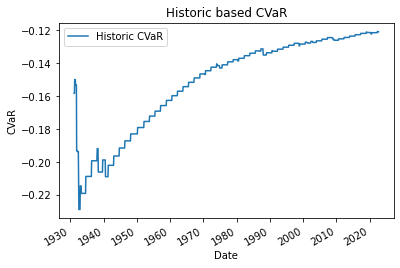

In [18]:
historic_CVaR_df.plot()

plt.title('Historic based CVaR')
plt.xlabel('Date')
plt.ylabel('CVaR')
plt.show()

#### (b) Frequency of periods when r_tilde is less than (a)

In [19]:
freq_hcv = len(bn[r'$\tilde{r}$'][bn[r'$\tilde{r}$'] < historic_CVaR_df['Historic CVaR']]) / len(historic_CVaR_df['Historic CVaR'])#
round(freq_hcv,4)

0.0078

#### (c) Drawback of historic based CVaR

Historic based CVaR here doesn't match the 5% percentail threshold. It takes lots of history data into account, which results in a backward-looking indicator. Similarly, it's not reflecting current or recent movement of market as it reacts slowly. In addition, historic measurement also assigns equal weights on even 'ancient' data inputs, which causes the result not reflecting current events properly. 

### 3.2 Volatility

#### (a) plot expanding and rolling CVaR

In [20]:
#empirical cdf with 0.05 CI
#(mu + alpha**-1 * norm.pdf(norm.ppf(alpha))* std) * portfolio_value
#https://medium.com/@nikeshshrestha/portfolio-var-and-cvar-3ab7546d1865
from scipy.stats import norm
#0 df
cvar = -stats.norm.pdf(1.65)* (0.05**-1)*vol
cvar = cvar.rename(columns={'Expanding Vol':'Expanding CVaR','Rolling Vol':'Rolling CVaR'})
#em_cvar

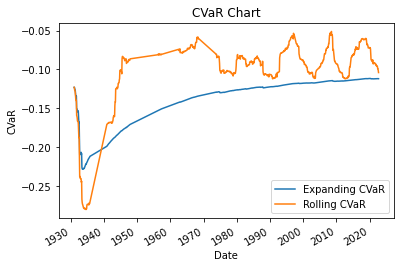

In [21]:
cvar.plot()

plt.title('CVaR Chart')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

#### (b) CVaR_.05 = -1.65 * vol

In [22]:
scaled_cv = norm.pdf(1.65)/0.05 * cvar
scaled_cv.head()

,Expanding CVaR,Rolling CVaR
date,,
1931-01-31,-0.2515,-0.2515
1931-02-28,-0.2514,-0.2535
1931-03-31,-0.2561,-0.2596
1931-04-30,-0.2567,-0.2603
1931-05-29,-0.2594,-0.2644


#### (c) Frequency of periods when r_tilde is less than (b)

In [23]:
freq_cv = pd.DataFrame(index=['Frequency'], columns = cvar.columns)

for col in freq_cv:
    freq_cv[col] = len(cvar[bn.loc[cvar.index, r'$\tilde{r}$'] < cvar[col]]) / len(cvar[col].dropna())
    
freq_cv

,Expanding CVaR,Rolling CVaR
Frequency,0.0098,0.0305


#### (d) Compare with frequency of historic based var

In [24]:
freq_cv['Historic CVaR'] = freq_hcv
freq_cv

,Expanding CVaR,Rolling CVaR,Historic CVaR
Frequency,0.0098,0.0305,0.0078


Here we see Expanding CVaR and Historic CVar have similar frequency and quite low comparing from rolling CVaR. It makes sense as expanding CVaR and historic CVaR are taking more historical data into account, while rolling CVarR uses the 60 day window.

## Estimating Underperformance

### 1.Summary Stats

#### (a) report stats

In [25]:
def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = [r'log $r^{M}$',r'log ${\tilde{r}^{M}}$',r'log $r^{f}$'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] *= np.sqrt(annual_factor)
    
    return df

def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

stats_ = join([annualized_stats(bn.loc['1965':'1999'], 12),
             annualized_stats(bn.loc['2000':], 12),
             annualized_stats(bn.loc['1926':], 12)])

log_stats = join([annualized_stats(log_bn.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_bn.loc['2000':], 12, log = True),
                 annualized_stats(log_bn.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)

In [26]:
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$
$r^{M}$,0.1294,0.1494,0.0759,0.1526,0.1135,0.1874
${\tilde{r}^{M}}$,0.0679,0.1502,0.0616,0.1531,0.0819,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log $r^{M}$,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log ${\tilde{r}^{M}}$,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


#### (b) Comment on stats

mean return is higher, the highest among the three duration, in early years from 1965 to 1999 compared to number of 2000 to 2022 and overall duration, 1926 to 2022; however, the excessive return in two intervals are similar and the overall duration has slightly higher excessive return.

the log return in term of 1965 to 1999 is the highest still, while the log excessive return of 2000 to 2022 is the lowest figure among the three.log sigmas of both mean return and excessive return in overall duration are the highest in both combinations and the earliest-year durations have lowest log-sigma.

### 2. Probabilities

#### (a)subsample 1965-1999

In [27]:

def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [28]:
mu_tilde = stats_df.iloc[4, 0]
sigma_tilde = stats_df.iloc[4, 1]
h = 2022 - 1999 

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
23,0.0364


#### (b)h=15, h=30

In [29]:
prob([15,30], mu_tilde, sigma_tilde)

,Probability
h,
15,0.0736
30,0.0202


#### (c)Plot the prob for 0 < h < 30

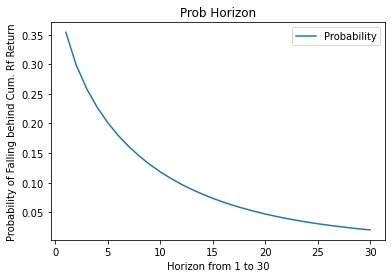

In [30]:
pb_horizon = prob(list(range(1,31)), mu_tilde, sigma_tilde)

pb_horizon.plot()
plt.title('Prob Horizon')
plt.ylabel('Probability of Falling behind Cum. Rf Return')
plt.xlabel('Horizon from 1 to 30')
plt.show()


### 3. 30-year Probabilities
sample from 1965 to 2022

In [31]:
#first construct the 1965 to 2022 dataframe
log_1965 = log_bn.loc['1965':].dropna()
mu_1965_t = (log_1965['SPX'].mean() - log_1965['TB1M'].mean())*12
sigma_65_t = (log_1965['SPX'] - log_1965['TB1M']).std() * (12**0.5)

prob(list(range(5,35,5)), mu_1965_t, sigma_65_t)

,Probability
h,
5,0.2124
10,0.1295
15,0.0834
20,0.0552
25,0.0372
30,0.0253


In [32]:
prob([30], mu_1965_t, sigma_65_t)

,Probability
h,
30,0.0253


### 4. Expectations

#### (a)Prob(23year-return < realized 2000-2022)
P(1999 < 2000-2022) => P('1999'-'2000-2022' < 0)

In [33]:
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$
$r^{M}$,0.1294,0.1494,0.0759,0.1526,0.1135,0.1874
${\tilde{r}^{M}}$,0.0679,0.1502,0.0616,0.1531,0.0819,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log $r^{M}$,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log ${\tilde{r}^{M}}$,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


In [34]:
mu = stats_df.iloc[3,0]
r_bar = stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]
h=2022-1999
#mu-r_bar
prob([h], mu-r_bar, sigma)

,Probability
h,
23,0.0429


#### (b)Put-Call implementation with strike = .06
prob(2000-2029 mkt is low enough for put to be profitable)

In [35]:
k = np.log(1.06)

mu_65 = log_1965['SPX'].mean()*12

sigma_65 = log_1965['SPX'].std() * (12** 0.5)

#mu = 22/8 * (stats_df.iloc[3,2] - k) + mu_65 - k

mu = 23/7 * (stats_df.iloc[3,2] - k) + mu_65 - k

prob([7], mu, sigma)

,Probability
h,
7,0.1539


In [36]:
mu

0.05765562898121819